In [2]:
from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4


In [3]:
load_dotenv()
llm = ChatGroq(model="openai/gpt-oss-120b")

In [4]:
search_tool = TavilySearchResults(max_results=4)
tools = [search_tool]

memory = MemorySaver()

llm_with_tools = llm.bind_tools(tools = tools)


C:\Users\Yash pandey\AppData\Local\Temp\ipykernel_18628\207660265.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=4)


In [5]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm_with_tools.ainvoke(state["messages"])
    return{
        "messages":[result],
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tool_node"
    else:
        return END

async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""

    tool_calls = state["messages"][-1].tool_calls

    tool_messages = []
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        if tool_name=="tavily_search_results_json":
            search_results = await search_tool.ainvoke(tool_args)

            tool_message = ToolMessage(
                content = str(search_results),
                tool_call_id = tool_id,
                name = tool_name
            )
            tool_messages.append(tool_message)

    return {"messages": tool_messages}


graph_builder = StateGraph(State)
graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router)
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)





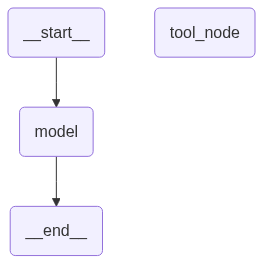

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [9]:
config = {
    "configurable":{
        "thread_id": 5
    }
}

response = await graph.ainvoke({
    "messages":[HumanMessage(content="Where is AI city is going to built in India?")],
    
}, config=config)

response

{'messages': [HumanMessage(content='Where is AI city is going to built in India?', additional_kwargs={}, response_metadata={}, id='f6323b05-1eda-4f42-8003-b26c9b55188f'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "Where is AI city is going to built in India?" They likely refer to an "AI City" project. Need to find location. Use search.', 'tool_calls': [{'id': 'fc_d9b04a86-4b72-4244-aff4-9edd7bc4bd42', 'function': {'arguments': '{"query":"AI City India location where will be built"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 165, 'total_tokens': 239, 'completion_time': 0.14728129, 'prompt_time': 0.00595056, 'queue_time': 0.046884838, 'total_time': 0.15323185}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ed9190d8b7', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7d6ab2a3-6f3e-4c06-9a44-9827c707